In [3]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


from IPython.display import SVG, Image
import tensorflow as tf
print("version:", tf.__version__)


version: 2.15.0


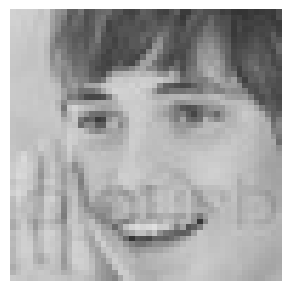

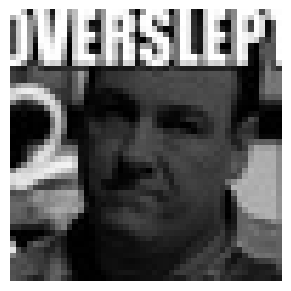

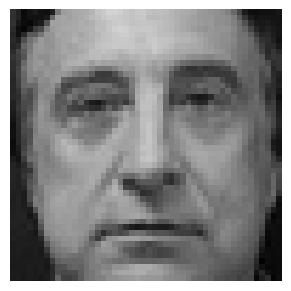

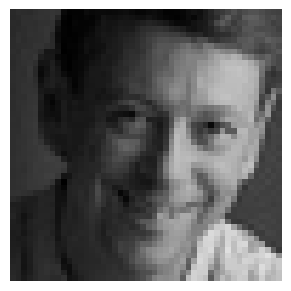

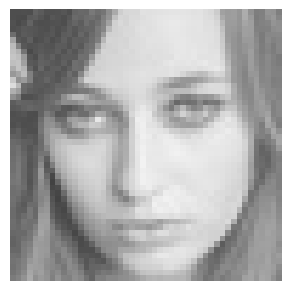

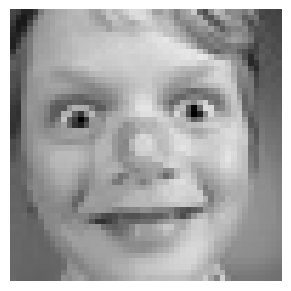

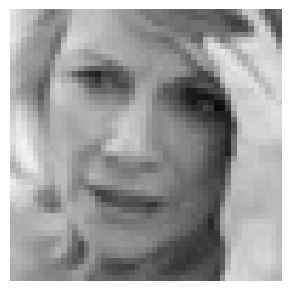

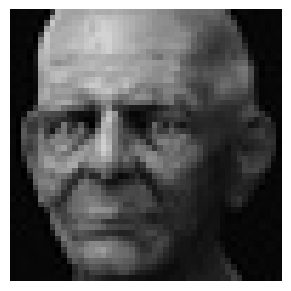

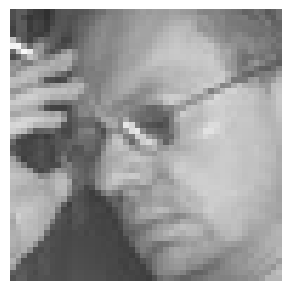

In [4]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify your parameters
img_size = 48
batch_size = 64

# Create an instance of ImageDataGenerator
datagen_train = ImageDataGenerator(horizontal_flip=True)

# Create a generator for the training data
train_generator = datagen_train.flow_from_directory(
    directory="train/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',  # or 'binary' depending on your task
    shuffle=True
)

# Create an instance of ImageDataGenerator
datagen_train = ImageDataGenerator(horizontal_flip=True)

# Create a generator for the training data
validation_generator = datagen_train.flow_from_directory(
    directory="test/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',  # or 'binary' depending on your task
    shuffle=True
)


Found 28517 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
def Convolution(input_tensor, filters, kernel_size):
  x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)

  return x
    

In [7]:
def Dense_f(input_tensor, nodes):
  x = Dense(nodes)(input_tensor)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.25)(x)

  return x

In [8]:
def model_fer(input_shape):
  inputs = Input(input_shape)
  conv_1 = Convolution(inputs, 64,(3,3))
  conv_2 = Convolution(inputs, 128,(5,5))
  conv_3 = Convolution(inputs, 512,(3,3))
  conv_4 = Convolution(inputs, 512,(3,3))

  flatten = Flatten()(conv_4)

  dense_1 = Dense_f(flatten,256)
  dense_2 = Dense_f(dense_1,512)

  output = Dense(7, activation = "softmax")(dense_2)
  model = Model(inputs = [inputs], outputs = [output])

  opt = Adam(lr=0.0005)

  model.compile(loss = ['categorical_crossentrophy'], optimizer = opt, metrics = ['accuracy'])

  return model

In [9]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 512)       5120      
                                                                 
 batch_normalization_3 (Bat  (None, 48, 48, 512)       2048      
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 48, 48, 512)       0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 512)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 512)       0     

In [10]:
epochs = 10
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode ='max', verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor =0.1, patience = 2,min_lr =0.00001 )
callbacks = [checkpoint,reduce_lr]

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you have correctly defined and created train_generator and valid_generator

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/10



445/445 [==============================] - 1326s 3s/step - loss: 1.7269 - accuracy: 0.3392 - val_loss: 1.8629 - val_accuracy: 0.2602
Epoch 2/10
445/445 [==============================] - 1531s 3s/step - loss: 1.4745 - accuracy: 0.4310 - val_loss: 1.6823 - val_accuracy: 0.2949
Epoch 3/10
445/445 [==============================] - 2271s 5s/step - loss: 1.3671 - accuracy: 0.4740 - val_loss: 1.6037 - val_accuracy: 0.3828
Epoch 4/10
445/445 [==============================] - 2083s 5s/step - loss: 1.2925 - accuracy: 0.5027 - val_loss: 1.6063 - val_accuracy: 0.3652
Epoch 5/10
445/445 [==============================] - 1751s 4s/step - loss: 1.2266 - accuracy: 0.5368 - val_loss: 1.5862 - val_accuracy: 0.3578
Epoch 6/10
445/445 [==============================] - 1700s 4s/step - loss: 1.1796 - accuracy: 0.5523 - val_loss: 1.4985 - val_accuracy: 0.4076
Epoch 7/10
445/445 [==============================] - 1399s 3s/step - loss: 1.1306 - accuracy: 0.5726 - val_loss: 1.4273 - val_accuracy: 0.4461
Epo

In [12]:
#MODEL EVALUATION
model.evaluate(validation_generator)


113/113 [==============================] - 58s 508ms/step - loss: 1.4550 - accuracy: 0.4468


[1.455027461051941, 0.44678184390068054]

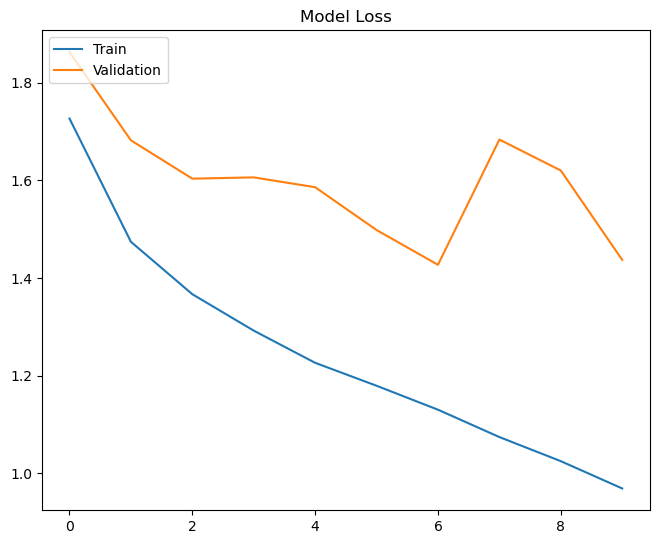

In [15]:
#PLOTTING LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

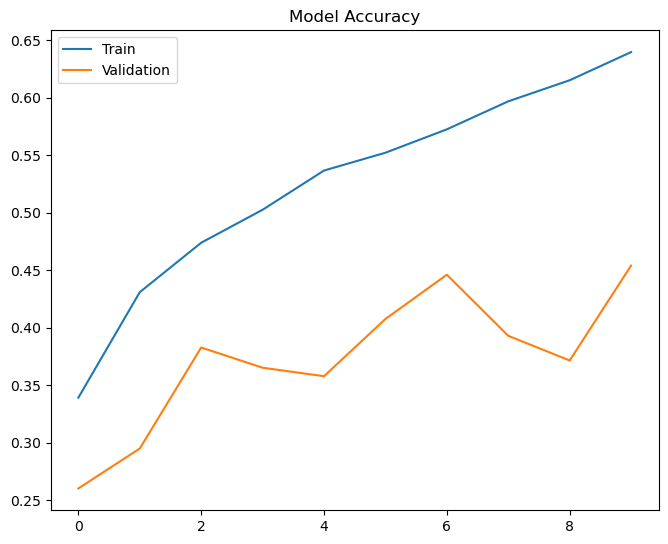

In [16]:
#MODEL ACCURACY
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [20]:
#SAVING THE MODEL
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
  json_file.write(model_json)

In [21]:
model.save_weights("model_weights.h5")
